# CNN Example in Pytorch
## STAT 940

### Introduction

In this tutorial we will train a simple Convolutional Neural Network in following five steps:
- Step 1)  Import libraries and set parameters
- Step 2) Load and prepare data
- Step 3) Model Definition
- Step 4) Set up optimizers and loss functions
- Step 5) Learning model and fit it on training data

Also we will see how to:
- Save and load learned models
- Predit labels of test data
- Check accuracy of model

### STEP 1 - Import libraries and set parameters

First, we will import the necessary libraries and packages that are needed for Convolutional Neural Network.
- 1) Numpy: NumPy is the fundamental package for scientific computing with Python
- 2) torch, torch.nn, torch.nn.functional, torch.optim: Pytorch imports for building custom neural networks containing
    - Sequential model type: This provides linear stack of neural network layers and it is usefull in MLP and CNN nets.
    - Core layers (Linear, Dropout, ReLU): these layers are used in most neural networks
    - Convolutional and maxpooling layers
    - data tools: DataSet for custom data sets, DataLoader for loading in data
    - optim: optimizers
- 3) torchvision: Vision specific Pytorch. Provides useful augmentations, datasets, pretrained models
- 4) matplotlib.pyplot: for plotting figures and images

In [1]:
# 1)
import numpy as np
# 2)
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
# 3)
import torchvision
# 4)
import matplotlib.pyplot as plt

In [2]:
np.random.seed(940) # set seed for reproducibility (within numpy)
torch.manual_seed(940) # set seed for reproducibility (within pytorch)

#### Parameters

In [3]:
batch_size = 256      #batch size
num_classes = 10      #number of classes
epochs = 100          #epoch size

#### Set-up GPU (optional)

Leverage GPUs for faster training of neural networks. This section will help you set up GPUs on Pytorch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # check is GPU is available
print(device)

cuda:0


### STEP 2 - Load and prepare data

In [5]:
train = torchvision.datasets.CIFAR10("./", train=True, download=True)
test = torchvision.datasets.CIFAR10("./", train=False, download=True)

print('# train:', len(train))
print("# test:", len(test))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
# train: 50000
# test: 10000


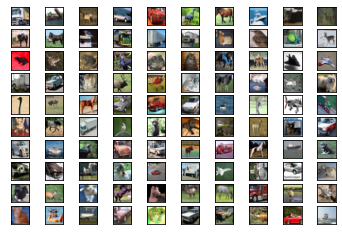

In [6]:
# show some images
plt.figure()                                      # create new figure
fig_size = [20, 20]                               # specify figure size
plt.rcParams["figure.figsize"] = fig_size         # set figure size

#Plot firs 100 train image of dataset
for i in range(1,101):                          
    ax = plt.subplot(10, 10, i)                   # Specify the i'th subplot of a 10*10 grid
    img = train[i][0]                             # train[i][0] is the image, train[i][1] is the label
    ax.get_xaxis().set_visible(False)             # Disable plot axis.
    ax.get_yaxis().set_visible(False)
    plt.imshow(img)
    
plt.show()

#### Prepare Data

In [7]:
# transforms
# first convert image to tensor with values in [0, 1]
# normalize image over all channels to be between [-1, 1]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# attach transforms to dataset
train = torchvision.datasets.CIFAR10("./", train=True, transform=transform, download=True)
test = torchvision.datasets.CIFAR10("./", train=False, transform=transform, download=True)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True) # shuffle training examples
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) # don't shuffle test set

Files already downloaded and verified
Files already downloaded and verified


### STEP 3 - Model Definition
Here, we will define a very simple Convolutional Neural Network, consist of three convolutional, MaxPooling and Dropout layers. Also, it ends up with two dense layers. ReLU activation function is used in all layers. A softmax layer is used in the last layer of the network.

Kernel size of each convolutional layer is:

Conv1 ===> 3 &#10005; 3 &#10005; 3 (we have 20 kernels in this size for the first convolutional layer)

Conv2 ===> 3 &#10005; 3 &#10005; 20 (we have 50 kernels in this size for the second convolutional layer)

Conv3 ===> 3 &#10005; 3 &#10005; 50 (we have 100 kernels in this size for the third convolutional layer)

In [8]:
# with logging
class Net_verbose(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(3, 3))
        
        # max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.25)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # dense layers
        self.fc1 = nn.Linear(400, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        print("Input Shape:", x.shape)
        x = self.pool(self.relu(self.conv1(x)))
        print("Shape after conv layer 1:", x.shape)
        x = self.pool(self.relu(self.conv2(x)))
        print("Shape after conv layer 2:", x.shape)
        x = self.pool(self.relu(self.conv3(x)))
        print("Shape after conv layer 3:", x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print("Shape after flatten:", x.shape)
        x = self.relu(self.fc1(x))
        print("Shape after dense layer 1:", x.shape)
        x = self.relu(self.fc2(x))
        print("Shape after dense layer 2:", x.shape)
        return x
    
# without logging
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(3, 3))
        
        # max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.25)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # dense layers
        self.fc1 = nn.Linear(400, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        
        x = self.pool(self.relu(self.conv1(x)))
        
        x = self.pool(self.relu(self.conv2(x)))
        
        x = self.pool(self.relu(self.conv3(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.relu(self.fc1(x))
        
        x = self.relu(self.fc2(x))
        
        return x



In [9]:
net = Net_verbose()

# test out on one batch of images - each batch is given as a list of [Images, Labels]
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]

print("Batch shape (image): ", images.shape)
print("Batch shape (label): ", labels.shape)

# feed batch to model
output = net(images)
print("Output shape:", output.shape)

Batch shape (image):  torch.Size([256, 3, 32, 32])
Batch shape (label):  torch.Size([256])
Input Shape: torch.Size([256, 3, 32, 32])
Shape after conv layer 1: torch.Size([256, 20, 15, 15])
Shape after conv layer 2: torch.Size([256, 50, 6, 6])
Shape after conv layer 3: torch.Size([256, 100, 2, 2])
Shape after flatten: torch.Size([256, 400])
Shape after dense layer 1: torch.Size([256, 512])
Shape after dense layer 2: torch.Size([256, 10])
Output shape: torch.Size([256, 10])


In [13]:
# model summary (without logging)
net = Net()
net = net.to(device) # move model to GPU
print(net)

Net(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### STEP 4 - Set up optimizers and loss functions

In [14]:
criterion = nn.CrossEntropyLoss() # cross entropy loss for loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # stochastic gradient descent as optimizer

#### Training Loop

In [25]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # move the data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.029
[1,    51] loss: 1.361
[1,   101] loss: 1.357
[1,   151] loss: 1.356
[2,     1] loss: 0.027
[2,    51] loss: 1.348
[2,   101] loss: 1.343
[2,   151] loss: 1.337
[3,     1] loss: 0.027
[3,    51] loss: 1.322
[3,   101] loss: 1.323
[3,   151] loss: 1.315
[4,     1] loss: 0.025
[4,    51] loss: 1.298
[4,   101] loss: 1.308
[4,   151] loss: 1.294
[5,     1] loss: 0.026
[5,    51] loss: 1.304
[5,   101] loss: 1.286
[5,   151] loss: 1.287
[6,     1] loss: 0.026
[6,    51] loss: 1.277
[6,   101] loss: 1.263
[6,   151] loss: 1.255
[7,     1] loss: 0.025
[7,    51] loss: 1.269
[7,   101] loss: 1.250
[7,   151] loss: 1.256
[8,     1] loss: 0.024
[8,    51] loss: 1.211
[8,   101] loss: 1.264
[8,   151] loss: 1.243
[9,     1] loss: 0.022
[9,    51] loss: 1.226
[9,   101] loss: 1.222
[9,   151] loss: 1.218
[10,     1] loss: 0.023
[10,    51] loss: 1.205
[10,   101] loss: 1.207
[10,   151] loss: 1.216
[11,     1] loss: 0.026
[11,    51] loss: 1.183
[11,   101] loss: 1.205
[11,

### Save the model and load the model

In [36]:
PATH = './cifar_net.pth'

torch.save(net.state_dict(), PATH) # save model to path

net = Net() # create new network
net.load_state_dict(torch.load(PATH)) # load the weights of saved model
net = net.to(device) # move network to gpu

### Make a prediction on the test set

In [37]:
dataiter = iter(test_loader)

with torch.no_grad(): # turns off gradient computation when predicting
    net.eval()
    images, labels = dataiter.next()
    images = images.to(device) # move images to gpu
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    print(predicted)
    print(labels)

    print(f"Accuracy: {sum(predicted.cpu().numpy() == labels.cpu().numpy())} / {labels.shape[0]}")

tensor([3, 8, 8, 0, 6, 6, 1, 2, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 2, 4, 9,
        4, 2, 4, 4, 1, 6, 6, 5, 4, 3, 9, 8, 7, 1, 9, 5, 0, 6, 3, 6, 0, 9, 3, 9,
        4, 2, 7, 8, 6, 3, 8, 8, 7, 5, 5, 4, 7, 5, 6, 2, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 2, 3, 3, 8, 8, 9, 1, 7, 0, 7, 4, 2, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 3, 4, 5, 6, 3, 1, 1, 0, 6, 3, 7, 7, 0, 2, 2, 1, 4, 0, 4, 3, 3,
        8, 2, 1, 2, 8, 0, 0, 3, 6, 0, 4, 1, 8, 9, 1, 2, 9, 7, 2, 8, 6, 5, 6, 3,
        8, 4, 6, 5, 5, 3, 0, 9, 6, 0, 0, 5, 2, 9, 3, 4, 0, 1, 6, 6, 0, 2, 8, 4,
        7, 0, 4, 0, 0, 8, 9, 9, 3, 7, 5, 0, 0, 5, 6, 2, 5, 8, 6, 3, 3, 0, 4, 8,
        0, 1, 7, 2, 8, 8, 5, 8, 5, 0, 8, 7, 1, 3, 8, 5, 7, 9, 5, 0, 2, 9, 8, 3,
        7, 9, 0, 4, 7, 3, 9, 7, 3, 1, 3, 4, 3, 5, 5, 1, 5, 8, 8, 0, 4, 0, 8, 3,
        1, 1, 8, 3, 0, 2, 1, 8, 2, 0, 5, 3, 9, 9, 2, 0], device='cuda:0')
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4,